In [1]:
%matplotlib inline

from math import ceil
from math import floor
from typing import Tuple
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import rearrange
from einops import repeat
from torch.nn import functional as F


FONTSIZE = 8
FPS = 30
DPI = 300  # I'm not sure it's correct
COLORMAP = "turbo" 

DATA_DIR = '/home/bethge/bkr618/openretina_cache/euler_lab/hoefling_2024/stimuli/rgc_natstim_72x64_joint_normalized_2024-10-11.pkl'
H, W = 72, 64

In [5]:
def set_spine(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_edgecolor("red")
        spine.set_linewidth(2)


def unfold_size(dim: int, patch_size: int, stride: int):
    return floor(((dim - patch_size) / stride) + 1)


def pad_size(dim: int, patch_size: int, stride: int):
    return (ceil(dim / stride) - 1) * stride + patch_size - dim


def zero_pad(frame: torch.Tensor, patch_size: int, stride: int):
    h_pad = pad_size(H, patch_size, stride)
    w_pad = pad_size(W, patch_size, stride)
    padding = (
        w_pad // 2,  # padding left
        w_pad - w_pad // 2,  # padding right
        h_pad // 2,  # padding top
        h_pad - h_pad // 2,  # padding bottom
    )
    print(f"pad: {padding}, frame shape: {frame.shape}")
    frame = rearrange(frame, "h w -> 1 h w")
    frame = F.pad(frame, pad=padding, mode="constant", value=0)
    # frame = F.pad(frame, pad=padding, mode="replicate")
    print(f"pad frame shape: {frame.shape}")
    frame = frame[0]
    return frame, padding


def unfold(frame: np.ndarray, patch_size: int, stride: int, pad: bool):
    frame = torch.from_numpy(frame)
    padding = None
    if pad:
        frame, padding = zero_pad(frame, patch_size, stride=stride)
    patches = frame.unfold(0, patch_size, stride).unfold(1, patch_size, stride)
    shape = patches.shape
    patches = rearrange(patches, "nh nw ph pw -> (nh nw) ph pw")
    patches = patches.numpy()
    return patches, shape, padding


def dropout(patches: np.ndarray, shape: Tuple[int, ...], p: float = 0.0):
    patches = torch.from_numpy(patches)
    patches = rearrange(patches, "n ph pw -> 1 n (ph pw)")
    patches = F.dropout(patches, p=p, training=True)
    patches = patches * (1 - p)  # dropout layer in PyTorch scale the output by 1/(1-p)
    patches = rearrange(patches, "1 n (ph pw) -> n ph pw", ph=shape[2], pw=shape[3])
    patches = patches.numpy()
    return patches


def dropout1d(patches: np.ndarray, shape: Tuple[int, ...], p: float = 0.0):
    patches = torch.from_numpy(patches)
    patches = rearrange(patches, "n ph pw -> 1 n (ph pw)")
    patches = F.dropout1d(patches, p=p, training=True)
    patches = patches * (1 - p)  # dropout layer in PyTorch scale the output by 1/(1-p)
    patches = rearrange(patches, "1 n (ph pw) -> n ph pw", ph=shape[2], pw=shape[3])
    patches = patches.numpy()
    return patches


def plot_patches(
    patches: np.ndarray,
    shape: tuple[int, int],
    title: str,
    cmap: str = "gray",
):
    nrows, ncols = shape[0], shape[1]
    figure, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(ncols * 0.1, nrows * 0.1),  # smaller scaling factor
        gridspec_kw={"wspace": 0.08, "hspace": 0.08},  # tight spacing
        facecolor="aquamarine",
        dpi=DPI,
    )
    axes = axes.ravel()
    for i in range(len(axes)):
        axes[i].imshow(patches[i], aspect="equal", cmap=cmap, vmin=0, vmax=1)
        axes[i].axis("off")
    top = axes[0].get_position()
    figure.text(
        x=0.5,
        y=top.y1 + 0.01,
        s=title,
        fontsize=FONTSIZE,
        ha="center",
    )
    plt.show()
    plt.close(figure)


def visualize_unfold(
    frame,
    patch_size: int = 7,
    stride: int = 2,
    p: float = 0.05,
):
    frame = frame / np.max(frame)

    figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 2), dpi=DPI)
    ax.imshow(frame, cmap="gray")
    ax.axis("off")
    plt.show()
    plt.close(figure)

    unfold_patches, shape, _ = unfold(
        frame, patch_size=patch_size, stride=stride, pad=False
    )
    plot_patches(unfold_patches, shape, title=f"unfold patches {shape} (no padding)")

    unfold_patches, shape, _ = unfold(
        frame, patch_size=patch_size, stride=stride, pad=True
    )
    plot_patches(unfold_patches, shape, title=f"unfold patches {shape} (with padding)")

    # dropout_patches = dropout(unfold_patches, shape, p=p)
    # plot_patches(dropout_patches, shape, title=f"dropout patches {shape} (p={p})")

    dropout1d_patches = dropout1d(unfold_patches, shape, p=p)
    plot_patches(dropout1d_patches, shape, title=f"dropout1d patches {shape} (p={p})")

In [2]:
from openretina.data_io.hoefling_2024.stimuli import movies_from_pickle
movies_path = '/home/bethge/bkr618/openretina_cache/euler_lab/hoefling_2024/stimuli/rgc_natstim_72x64_joint_normalized_2024-10-11.pkl'
movies_dict = movies_from_pickle(movies_path)

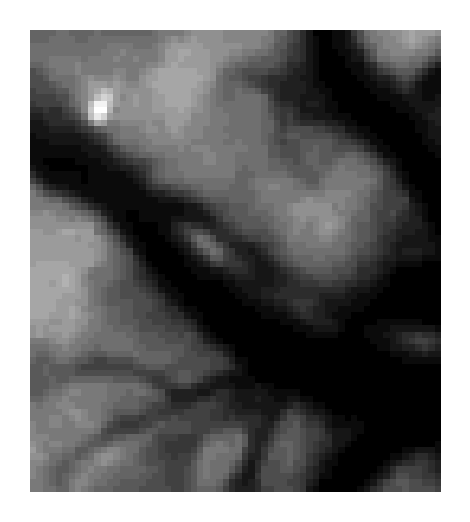

In [58]:
import random
movies = movies_dict.train
idx = random.randint(0,movies.shape[1])
example_frame = movies_dict.train[:,idx,:,:]
frame = example_frame[0] / np.max(example_frame[0])

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 2), dpi=DPI)
ax.imshow(frame, cmap="gray")
ax.axis("off")
plt.show()
plt.close(figure)

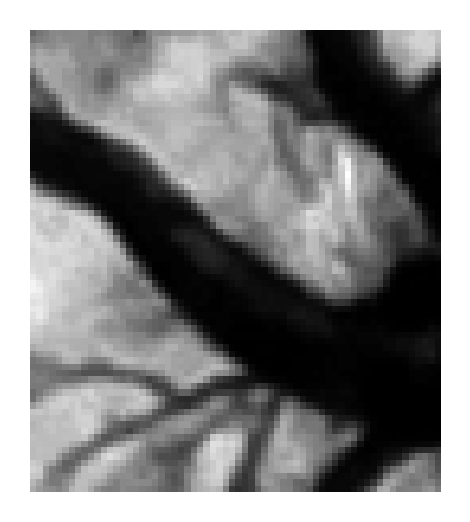

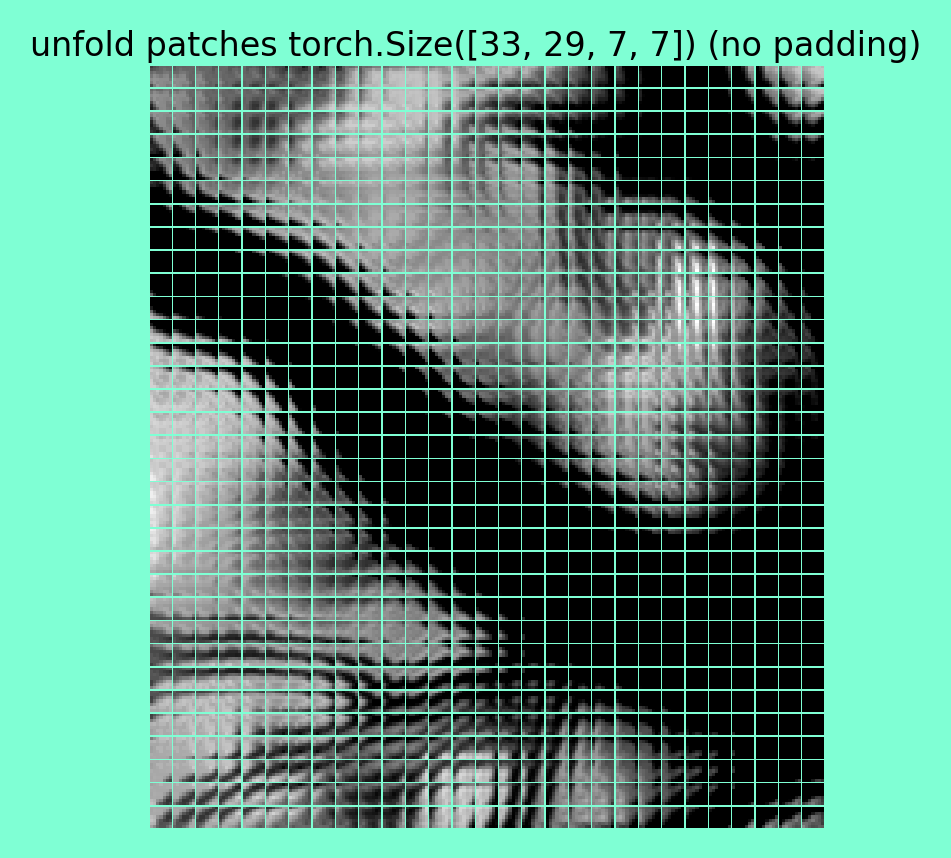

pad: (2, 3, 2, 3), frame shape: torch.Size([72, 64])
pad frame shape: torch.Size([1, 77, 69])


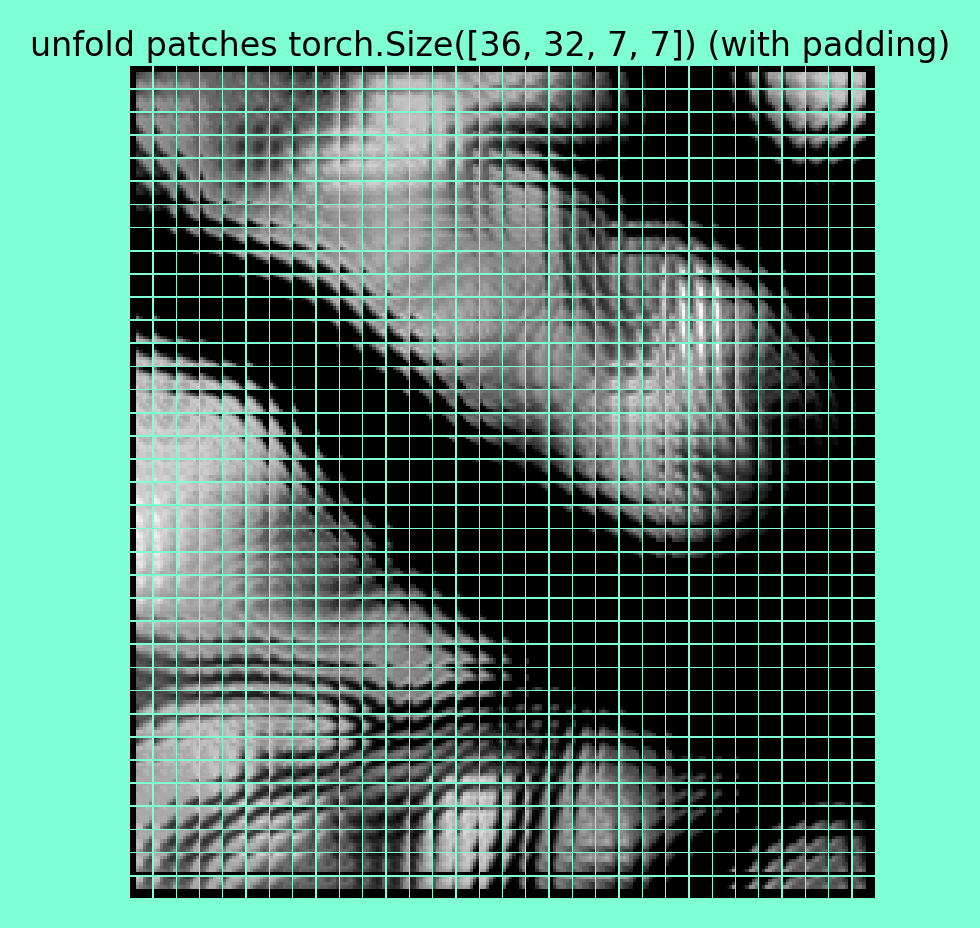

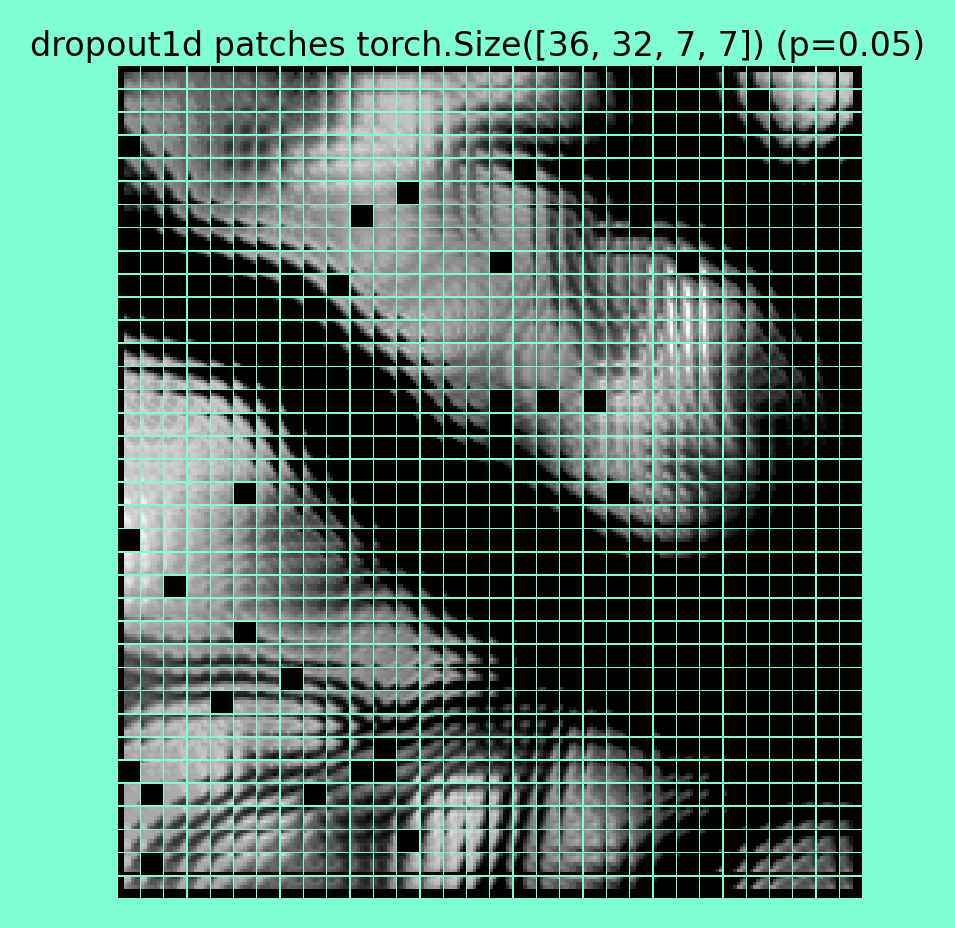

In [59]:
visualize_unfold(example_frame[1], patch_size=7, stride=2, p=0.05)

In [3]:
def fold(
    patches: np.ndarray,
    patch_size: int,
    stride: int,
    shape: Tuple[int, int],
    padding: Tuple[int, int, int, int],
):
    patches = torch.from_numpy(patches)
    if patches.size(1) == patches.size(2) == 1:
        patches = repeat(patches, "n 1 1 -> n ph pw", ph=patch_size, pw=patch_size)
    patches = rearrange(patches, "n ph pw -> 1 (ph pw) n")
    shape = (shape[0] + padding[2] + padding[3], shape[1] + padding[0] + padding[1])
    frame = F.fold(
        patches,
        output_size=shape,
        kernel_size=patch_size,
        stride=stride,
    )
    frame = frame[:, :, padding[2] : -padding[3], padding[0] : -padding[1]]
    frame = frame.numpy()
    return frame



# After training, just call this:
def quick_visualize(model, video_input, frame_image):
    """
    video_input: (B, T, P, C) from your model pipeline
    frame_image: original frame as numpy array
    """
    attn = model.get_spatial_attention_maps(video_input, layer_idx=-1)
    
    # Get first frame, first head, average over queries
    attn_map = attn[0, 0].mean(0).cpu().numpy()
    
    # Simple visualization
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(frame_image)
    plt.title('Original')
    plt.subplot(122)
    plt.imshow(attn_map.reshape(int(np.sqrt(len(attn_map))), -1), cmap='hot')
    plt.title('Attention')
    plt.show()

# Usage:
quick_visualize(model, input_tokens, frame)

def visualize_fold(frame):

    frame = frame / np.max(frame)

    patch_size, stride = 7, 2

    figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 2), dpi=DPI)
    ax.imshow(frame, cmap="gray")
    ax.axis("off")
    ax.set_title(f"frame {frame.shape}", fontsize=7, pad=0)
    plt.show()
    plt.close(figure)

    unfold_patches, shape, padding = unfold(
        frame, patch_size=patch_size, stride=stride, pad=True
    )
    plot_patches(unfold_patches, shape, title=f"unfold patches {shape}")

    # plot re-fold reconstruction
    fold_patches = fold(
        unfold_patches,
        patch_size=patch_size,
        stride=stride,
        shape=(H, W),
        padding=padding,
    )
    fold_patches = rearrange(fold_patches, "1 1 h w -> h w")
    figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3), dpi=DPI)
    axes[0].imshow(frame, cmap="gray")
    axes[1].imshow(fold_patches, cmap="gray")
    axes[0].set_title("original", fontsize=7, pad=0)
    axes[1].set_title("re-fold", fontsize=7, pad=0)
    axes[0].axis("off")
    axes[1].axis("off")
    plt.show()
    plt.close(figure)

    # plot re-fold reconstruction normalized by fold_one
    fold_patch_ones = fold(
        np.ones_like(unfold_patches),
        patch_size=patch_size,
        stride=stride,
        shape=(H, W),
        padding=padding,
    )
    fold_patches2 = fold_patches / fold_patch_ones
    fold_patches2 = rearrange(fold_patches2, "1 1 h w -> h w")
    figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3), dpi=DPI)
    axes[0].imshow(frame, cmap="gray")
    axes[1].imshow(fold_patches2, cmap="gray")
    axes[0].set_title("original", fontsize=7, pad=0)
    axes[1].set_title(
        f"re-fold / fold_ones (allclose: {np.allclose(frame, fold_patches2)})",
        fontsize=7,
        pad=0,
    )
    axes[0].axis("off")
    axes[1].axis("off")
    plt.show()
    plt.close(figure)

    # generate random attention map
    attention_map = get_attention(width=shape[1], height=shape[0])
    attention_map = attention_map / np.max(attention_map)
    attention_map = rearrange(attention_map, "h w -> (h w) 1 1")
    plot_patches(
        attention_map,
        shape=(shape[0], shape[1]),
        title=f"attention map {attention_map.shape}",
        cmap="viridis",
    )

    alpha = 0.6
    turbo = matplotlib.colormaps["turbo"]
    turbo_color = turbo(np.arange(256))[:, :3]
    # apply attention to patches
    heatmap = turbo_color[np.uint8(255.0 * attention_map)]
    overlay = alpha * heatmap + (1 - alpha) * unfold_patches[..., None]
    plot_patches(overlay, shape, title=f"attention overlay", cmap=turbo)

    fold_attention = fold(
        attention_map,
        patch_size=patch_size,
        stride=stride,
        shape=(H, W),
        padding=padding,
    )
    fold_attention1 = fold_attention / np.max(fold_attention)
    fold_attention1 = rearrange(fold_attention1, "1 1 h w -> h w")

    figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 2), dpi=DPI)
    ax.imshow(fold_attention1, cmap=turbo, vmin=0, vmax=1)
    ax.axis("off")
    ax.set_title(f"fold attention {fold_attention1.shape}", fontsize=7, pad=0)
    plt.show()
    plt.close(figure)

    fold_ones = fold(
        np.ones_like(attention_map),
        patch_size=patch_size,
        stride=stride,
        shape=(H, W),
        padding=padding,
    )
    fold_attention2 = fold_attention / fold_ones
    fold_attention2 = rearrange(fold_attention2, "1 1 h w -> h w")

    figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 2), dpi=DPI)
    ax.imshow(fold_attention2, cmap=turbo, vmin=0, vmax=1)
    ax.axis("off")
    ax.set_title(
        f"fold attention / fold_ones {fold_attention2.shape}", fontsize=7, pad=0
    )
    plt.show()
    plt.close(figure)

    heatmap = turbo_color[np.uint8(255.0 * fold_attention2)]
    overlay = alpha * heatmap + (1 - alpha) * frame[..., None]
    figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 2), dpi=DPI)
    ax.imshow(overlay, cmap=turbo, vmin=0, vmax=1)
    ax.axis("off")
    ax.set_title(f"overlay frame {overlay.shape}", fontsize=7, pad=0)
    plt.show()
    plt.close(figure)


visualize_fold(example_frame[0])

NameError: name 'np' is not defined

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from openretina.modules.core.transformer_core import ViViTCoreWrapper

def train_core_only(core_model, train_loader, num_epochs, device='cuda'):
    """
    Train just the core model.
    """
    core_model = core_model.to(device)
    core_model.train()
    
    optimizer = torch.optim.Adam(core_model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()  # Or your loss function
    
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (videos, targets) in enumerate(train_loader):
            videos = videos.to(device)  # (B, T, C, H, W)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass through core only
            outputs = core_model(videos)  # Your core forward pass
            
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}], Loss: {loss.item():.4f}")
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] completed. Avg Loss: {avg_loss:.4f}")
        
        # Save checkpoint
        torch.save(core_model.state_dict(), f'core_checkpoint_epoch_{epoch+1}.pth')
    
    return core_model


# Example usage:
core = ViViTCoreWrapper(
    in_shape= [128,2,50,72,64],
    patch_size= 8,
    temporal_patch_size= 6,
    spatial_stride= 6,
    temporal_stride= 1,
    Demb= 96,
    ptoken= 0.2,
    pad_frame= True,
    norm= "layernorm",
    patch_mode= True,
    pos_encoding= 4,
    num_heads= 4,
    reg_tokens= 10,
    num_spatial_blocks= 2,
    num_temporal_blocks= 2,
    dropout= 0.3,
    mlp_ratio= 4.0,
    ff_activation= "gelu",
    drop_path= 0.1,
    use_rope= True,
    use_causal_attention= True
    )

trained_core = train_core_only(core, train_loader, num_epochs=50)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from einops import rearrange

def extract_and_visualize_attention(
    core_model,         # Your trained ViViT core
    tokenizer,          # Your tokenizer
    video_input,        # (B, T, C, H, W) - single frame is fine
    frame_image,        # Original frame numpy (H, W, C)
    patch_size,
    stride,
    layer_idx=-1,
    head_idx=0,
    save_path='attention_map.png'
):
    """
    Extract attention from trained core and visualize.
    """
    device = next(core_model.parameters()).device
    core_model.eval()
    
    with torch.no_grad():
        # Step 1: Tokenize the input
        video_input = video_input.to(device)
        tokens = tokenizer(video_input)  # → (B, T, P, D)
        
        # Step 2: Extract attention maps from core
        attn_maps = core_model.get_spatial_attention_maps(tokens, layer_idx=layer_idx)
        
        if attn_maps is None:
            print("Failed to extract attention maps")
            return None
        
        # Step 3: Process attention
        # attn_maps: (B*T, num_heads, P, P)
        attn = attn_maps[0, head_idx]  # First frame, specific head
        attn_avg = attn.mean(dim=0).cpu().numpy()  # Average over queries
        
        # Step 4: Reshape to spatial grid
        h, w = frame_image.shape[:2]
        num_patches_h = (h - patch_size) // stride + 1
        num_patches_w = (w - patch_size) // stride + 1
        
        attn_map = attn_avg[:num_patches_h * num_patches_w]
        attn_map = attn_map.reshape(num_patches_h, num_patches_w)
        
        # Step 5: Resize to original size
        zoom_factors = (h / num_patches_h, w / num_patches_w)
        attn_resized = zoom(attn_map, zoom_factors, order=1)
        
        # Normalize to [0, 1]
        attn_resized = (attn_resized - attn_resized.min()) / (attn_resized.max() - attn_resized.min() + 1e-8)
        
        # Step 6: Plot
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(frame_image)
        axes[0].set_title('Original Frame')
        axes[0].axis('off')
        
        axes[1].imshow(attn_resized, cmap='hot')
        axes[1].set_title(f'Attention Map\n(Layer {layer_idx}, Head {head_idx})')
        axes[1].axis('off')
        
        axes[2].imshow(frame_image)
        axes[2].imshow(attn_resized, cmap='hot', alpha=0.5)
        axes[2].set_title('Overlay')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"Attention map saved to {save_path}")
        
        return attn_resized


# COMPLETE USAGE EXAMPLE:

# 1. Load your trained core
from your_model import ViViT, Tokenizer, YourArgs

args = YourArgs()  # Your config
core = ViViT(args, input_shape=(num_time_patches, num_spatial_patches, embed_dim))
core.load_state_dict(torch.load('core_checkpoint_epoch_50.pth'))
core = core.to('cuda')
core.eval()

# 2. Create tokenizer
tokenizer = Tokenizer(...)  # Your tokenizer config

# 3. Load a frame
import cv2
frame = cv2.imread('test_frame.jpg')
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Convert to tensor (B, T, C, H, W) - single frame
frame_tensor = torch.from_numpy(frame).permute(2, 0, 1).unsqueeze(0).unsqueeze(0).float()
frame_tensor = frame_tensor / 255.0  # Normalize if needed

# 4. Extract and visualize
attention_map = extract_and_visualize_attention(
    core_model=core,
    tokenizer=tokenizer,
    video_input=frame_tensor,
    frame_image=frame,
    patch_size=16,  # Your config
    stride=16,      # Your config
    layer_idx=-1,   # Last layer
    head_idx=0,     # First attention head
    save_path='my_attention_map.png'
)

In [ ]:
def visualize_all_heads(core_model, tokenizer, video_input, frame_image, patch_size, stride, layer_idx=-1):
    """
    Visualize all attention heads at once.
    """
    device = next(core_model.parameters()).device
    core_model.eval()
    
    with torch.no_grad():
        video_input = video_input.to(device)
        tokens = tokenizer(video_input)
        attn_maps = core_model.get_spatial_attention_maps(tokens, layer_idx=layer_idx)
        
        if attn_maps is None:
            return None
        
        num_heads = attn_maps.shape[1]
        
        # Create subplot for each head
        cols = 4
        rows = (num_heads + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
        axes = axes.flatten() if num_heads > 1 else [axes]
        
        h, w = frame_image.shape[:2]
        num_patches_h = (h - patch_size) // stride + 1
        num_patches_w = (w - patch_size) // stride + 1
        
        for head_idx in range(num_heads):
            attn = attn_maps[0, head_idx].mean(dim=0).cpu().numpy()
            attn_map = attn[:num_patches_h * num_patches_w].reshape(num_patches_h, num_patches_w)
            
            zoom_factors = (h / num_patches_h, w / num_patches_w)
            attn_resized = zoom(attn_map, zoom_factors, order=1)
            attn_resized = (attn_resized - attn_resized.min()) / (attn_resized.max() - attn_resized.min() + 1e-8)
            
            axes[head_idx].imshow(frame_image)
            axes[head_idx].imshow(attn_resized, cmap='hot', alpha=0.5)
            axes[head_idx].set_title(f'Head {head_idx}')
            axes[head_idx].axis('off')
        
        # Hide unused subplots
        for idx in range(num_heads, len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.savefig('all_heads_attention.png', dpi=150, bbox_inches='tight')
        plt.show()


# Usage:
visualize_all_heads(core, tokenizer, frame_tensor, frame, patch_size=16, stride=16)